In [3]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt


# 1 Carga de datos

#  Definir la ruta al dataset de forma relativa
ruta_csv = Path("diabetes_prediction_dataset.csv")

#  Cargar el dataset
datos = pd.read_csv(ruta_csv)

#  Seleccionar las columnas solicitadas
datosR = datos[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']]

#2 Limpieza de datos

#  Eliminar filas con valores nulos (si existen)
datos_limpios = datosR.dropna()

#  Definir los rangos válidos para cada columna
rangos = {
    'age': (0, 80),
    'bmi': (10.16, 71.55),
    'HbA1c_level': (0, 100)  
    }
#  Filtrar los datos para mantener solo aquellos que están dentro de los rangos válidos
datos_validos = datos_limpios[
    (datos_limpios['age'].between(*rangos['age'])) &
    (datos_limpios['bmi'].between(*rangos['bmi'])) &
    (datos_limpios['HbA1c_level'].between(*rangos['HbA1c_level'])) 
   ]

#  Separar características y variable objetivo
X = datos_validos[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]
y = datos_validos['diabetes']

# Detallar cuantos datos fueron eliminados en funcion de su rango y/o valores nulos

print(f"Datos iniciales: {datosR.shape[0]}")
print(f"Datos después de limpieza: {datos_validos.shape[0]}")

# 3 Evaluación del modelo KNN con K=1, 10-fold cross validation, y min_max()

#  Configurar KNN y 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform')

#  Función para normalizar usando Min-Max Scaling
def min_max_scaler(train, test):
    scaler = MinMaxScaler()
    scaler.fit(train)  # Ajustar el escalador solo con el conjunto de entrenamiento
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return train_scaled, test_scaled
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Normalizar los datos
    X_train_scaled, X_test_scaled = min_max_scaler(X_train, X_test)
    
    # Entrenar el modelo
    knn.fit(X_train_scaled, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = knn.predict(X_test_scaled)
    
    # Calcular la precisión
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

#  Mostrar resultados
accuracy_promedio = np.mean(accuracies)
accuracy_desviacion = np.std(accuracies)

print(f"Precisión promedio: {accuracy_promedio:.2f}")
print(f"Desviación estándar: {accuracy_desviacion:.2f}")

Datos iniciales: 100000
Datos después de limpieza: 99979
Precisión promedio: 0.95
Desviación estándar: 0.00


NOTA: Se normaliza porque KNN es sensible a las escalas de las variables. Si no se normaliza, variables como "blood_glucose_level" podrían dominar la distancia euclidiana, sesgando el resultado. Se usó MinMaxScaler para llevar cada variable a un rango entre 0 y 1, ajustando el scaler sólo con los datos de entrenamiento para evitar filtraciones de información del set de test.

La precision promedio fue de 95% lo cual es significativamente alto, esto implica que el modelo es bueno para predecir si una persona tendra diabetes o no. La desviacion estandar fue de 0, esto significa que el modelo tendra el mismo desempeño para los 10 folds realizados. Esta desviacion podria ser indicio de que exista una distribucion homogenea de los datos, o que el modelo sea demasiado simple (un k muy bajo). Para comprobar esto ultimo hay que cambiar K y ver que sucede.

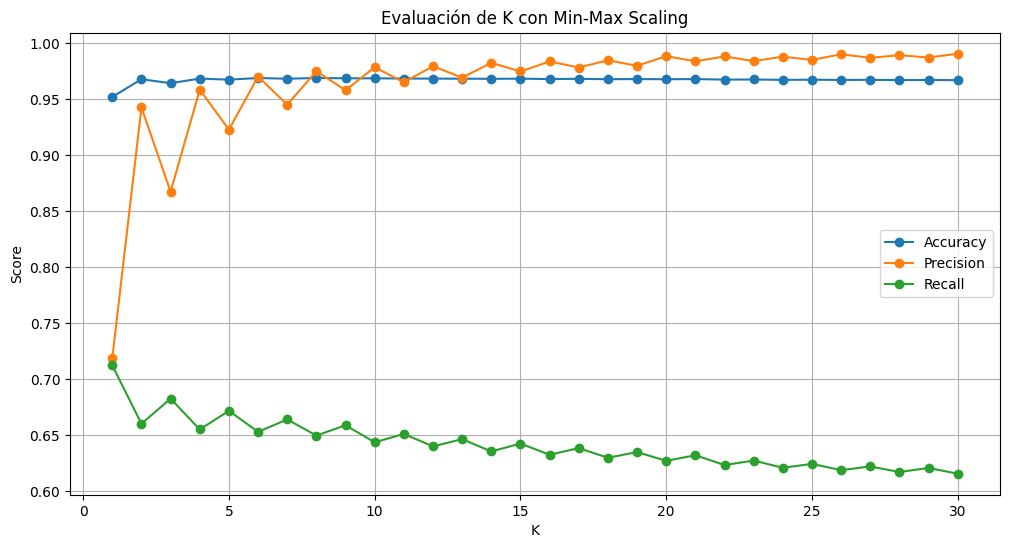

El mejor K basado en el balance de las métricas es: 8


In [4]:
# 4 Encontrar el Mejor K
# Evaluar el modelo KNN con diferentes valores de K (1 a 30)
k_values = range(1, 31)
accuracy_scores = []
precision_scores = []
recall_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform',n_jobs=-1)
    accuracies = []
    precisions = []
    recalls = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Normalizar los datos 
        X_train_scaled, X_test_scaled = min_max_scaler(X_train, X_test)
        
        # Entrenar el modelo
        knn.fit(X_train_scaled, y_train)
        
        # Predecir en el conjunto de prueba
        y_pred = knn.predict(X_test_scaled)
        
        # Calcular métricas
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
    
    # Promediar las métricas para el valor actual de K
    accuracy_scores.append(np.mean(accuracies))
    precision_scores.append(np.mean(precisions))
    recall_scores.append(np.mean(recalls))

# Graficar las métricas
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracy_scores, label='Accuracy', marker='o')
plt.plot(k_values, precision_scores, label='Precision', marker='o')
plt.plot(k_values, recall_scores, label='Recall', marker='o')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Evaluación de K con Min-Max Scaling')
plt.legend()
plt.grid()
plt.show()


# Identificar el mejor K basado en un balance de las métricas
best_k_index = np.argmax([accuracy_scores[i] + precision_scores[i] + recall_scores[i] for i in range(len(k_values))])
best_k = k_values[best_k_index]

print(f"El mejor K basado en el balance de las métricas es: {best_k}")

In [5]:
# 4 Evaluación del modelo KNN con K=8, 10-fold cross validation, y min_max()

#  Configurar KNN y 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=8, weights='uniform')

#  Función para normalizar usando Min-Max Scaling
def min_max_scaler(train, test):
    scaler = MinMaxScaler()
    scaler.fit(train)  # Ajustar el escalador solo con el conjunto de entrenamiento
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return train_scaled, test_scaled
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Normalizar los datos
    X_train_scaled, X_test_scaled = min_max_scaler(X_train, X_test)
    
    # Entrenar el modelo
    knn.fit(X_train_scaled, y_train)
    
    # Predecir en el conjunto de prueba
    y_pred = knn.predict(X_test_scaled)
    
    # Calcular la precisión
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

#  Mostrar resultados
accuracy_promedio = np.mean(accuracies)
accuracy_desviacion = np.std(accuracies)

print(f"Precisión promedio: {accuracy_promedio:.2f}")
print(f"Desviación estándar: {accuracy_desviacion:.2f}")

Precisión promedio: 0.97
Desviación estándar: 0.00


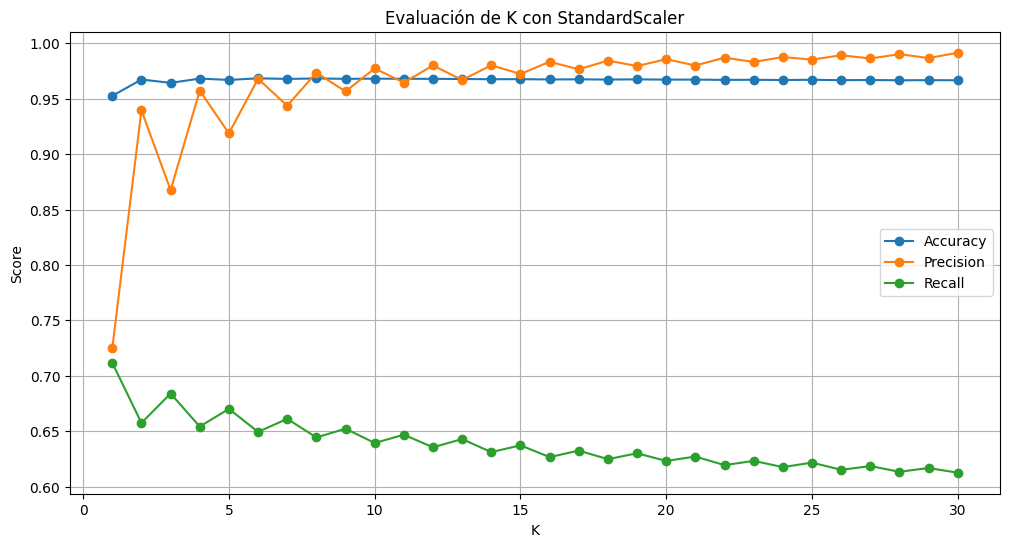

El mejor K con StandardScaler es: 8


In [6]:
# 5 Discusion ¿normalizacion o estandarización?

# Reconfigurar KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Función para escalar usando StandardScaler
def standard_scaler(train, test):
    scaler = StandardScaler()
    scaler.fit(train)  # Ajustar el escalador solo con el conjunto de entrenamiento
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return train_scaled, test_scaled

# Listas para almacenar las métricas
accuracy_scores_std = []
precision_scores_std = []
recall_scores_std = []

# Evaluar K=1 a 30
k_values = range(1, 31)
best_k_std = None
best_score_std = -1

# Recorrer valores de K
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Normalizar con StandardScaler
        X_train_scaled, X_test_scaled = standard_scaler(X_train, X_test)

        # Entrenar el modelo
        knn.fit(X_train_scaled, y_train)

        # Predicciones
        y_pred = knn.predict(X_test_scaled)

        # Métricas
        fold_accuracies.append(accuracy_score(y_test, y_pred))
        fold_precisions.append(precision_score(y_test, y_pred, zero_division=0))
        fold_recalls.append(recall_score(y_test, y_pred, zero_division=0))

    # Promediar métricas para el valor actual de K
    avg_score = np.mean(fold_accuracies) + np.mean(fold_precisions) + np.mean(fold_recalls)
    accuracy_scores_std.append(np.mean(fold_accuracies))
    precision_scores_std.append(np.mean(fold_precisions))
    recall_scores_std.append(np.mean(fold_recalls))

    # Actualizar el mejor K si es necesario
    if avg_score > best_score_std:
        best_score_std = avg_score
        best_k_std = k

# Graficar las métricas
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracy_scores_std, label='Accuracy', marker='o')
plt.plot(k_values, precision_scores_std, label='Precision', marker='o')
plt.plot(k_values, recall_scores_std, label='Recall', marker='o')
plt.xlabel('K')
plt.ylabel('Score')
plt.title('Evaluación de K con StandardScaler')
plt.legend()
plt.grid()
plt.show()

print(f"El mejor K con StandardScaler es: {best_k_std}")



#2 Se eliminaron los datos que fueran valores nulos y aquellos datos que se salieran de los rangos especificados por el enunciado.


#4 El mejor K sera el que tenga los mejores valores de las 3 metricas usadas. En base al análisis de los distintos K encontramos que el mejor es K=8
Al hacer el punto 3 con K=8, el accuracy promedio subio a 97% y la desviacion estandar se mantuvo en 0. Esto significa que efectivamente hubo una mejora en la precision del modelo al considerar K=8, y que este modelo tendra el mismo desempeño para cualquiera de los 10 folds que se hicieron. 